# 공유 오피스 무료 체험 사용자의 결제 전환 예측 모델 개발

- 프로젝트 개요
    - 공유오피스 출입 데이터를 바탕으로 무료 체험 사용자의 결제 전환 예측을 위한 머신러닝 모델을 개발
- 사용 데이터 셋
    - 공유 오피스 서비스의 2년 8개월치(2021.05.01~2023.12.31) 데이터

# 환경설정

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install koreanize_matplotlib -q
import koreanize_matplotlib
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [ ]:
site_area = pd.read_csv('/content/drive/MyDrive/코드잇_데이터분석_6기/99_중급프로젝트2/site_area.csv')
access = pd.read_csv('/content/drive/MyDrive/코드잇_데이터분석_6기/99_중급프로젝트2/trial_access_log.csv')
payment = pd.read_csv('/content/drive/MyDrive/코드잇_데이터분석_6기/99_중급프로젝트2/trial_payment.csv')
register = pd.read_csv('/content/drive/MyDrive/코드잇_데이터분석_6기/99_중급프로젝트2/trial_register.csv')
visit = pd.read_csv('/content/drive/MyDrive/코드잇_데이터분석_6기/99_중급프로젝트2/trial_visit_info.csv')

# 데이터 전처리

In [ ]:
# 중복값 제거
access.drop_duplicates(keep='first', inplace=True)
payment.drop_duplicates(keep='first', inplace=True)
register.drop_duplicates(keep='first', inplace=True)
visit.drop_duplicates(keep='first', inplace=True)

In [ ]:
# 데이트타임 변경
access['cdate'] = pd.to_datetime(access['cdate'])
register['trial_date'] = pd.to_datetime(register['trial_date'])
visit['date'] = pd.to_datetime(visit['date'])
visit['first_enter_time'] = pd.to_datetime(visit['first_enter_time'], format='mixed')
visit['last_leave_time'] = pd.to_datetime(visit['last_leave_time'], format='mixed')

## 데이터 오류값 처리

| 테이블 | 이상치 내용 | 이상치 원인 |
| --- | --- | --- |
| trial_register | ‘신규 가입자는 딱 1번 3일 체험을 이용할 수 있음’에도 불구하고 1) 같은 날 2회 3일 체험을 신청하거나 2) 서로 다른 날 2회 3일 체험을 신청한 경우가 존재함 | 1) 같은 날 2회 3일 체험을 신청한 경우 : 전산 오류로 인해 직접 현장 매니저들이 임시로 3일 체험할 수 있게 권한 부여를 직접 한 케이스 2) 서로 다른 날 2회 3일 체험을 신청한 경우 : 3일 체험을 신청했는데 방문을 못해서 다른 날에 재신청한 케이스 |
| trial_visit_info  | 1) stay_time은 결측치가 없는데, first_enter_time 혹은 last_leave_time이 결측치인 경우 2) stay_time이 first_enter_time, last_leave_time과 안 맞는 경우가 존재함. | 1) 최초 입실 / 최종 퇴실을 할 때 앞에 분에 따라 들어오는 경우가 있어서 기록이 남지 않는 경우 있음. 2) first_enter_time은 최초입실시각, last_leave_time은 최종퇴실시각을 의미함. stay_time은 순수 체류시간을 의미하기 때문에 중간에 잠깐 퇴실한 경우가 있을 수 있으므로 맞지 않을 수 있음. |

### register (3일 체험 신청 사용자)

- 중복값 제거 후 9,631명의 사용자
    - 같은 날 2회 신청(전산 오류) 사용자와, 다른 날 2회 신청(재신청) 사용자
        - register에서 user_uuid 기준 중복 사용자 찾기
        - 중복 사용자 제거

In [ ]:
# register 이상치 확인
duplicates = register[register['user_uuid'].duplicated(keep=False)]
duplicates = pd.merge(duplicates, visit, on='user_uuid', how='left')
duplicates = duplicates.drop_duplicates(subset=['user_uuid', 'date'], keep='first')
register.shape

(9631, 2)

In [ ]:
# register 이상치 제거
dup_ids = duplicates['user_uuid'].unique()
register = register[~register['user_uuid'].isin(dup_ids)]
register.shape

(9617, 2)

### visit (방문 사용자)

- visit 이상치 처리
    - 입, 퇴실 시간보다 순수 체류 시간인 'stay_time'이 더 중요한 지표
    - 'first_enter_time', 'last_leave_time' 컬럼을 제거 후 'stay_time' 컬럼만 사용

### 3일 체험 신청 후 방문하지 않은 사용자

- 결측치 제거하지 않고 특정 값으로 채우기
    - 정보 손실 방지: 결측치를 특정 값으로 채우면, 해당 사용자의 다른 유효한 정보는 유지하며 결측된 피처에 대한 정보를 모델에 전달
    - 결측치 자체의 의미 활용:
        - 예: 총 체류 시간이 결측치인 것은 '방문 기록이 없다'는 의미
        - 방문 기록이 없다는 것은 결제 여부를 예측하는 데 매우 중요한 정보
        - fillna(0)은 '기록이 없다'는 것을 '값이 0이다'로 해석해 모델에 전달
        - 값이 0인 것이 합리적인 가정이 될 수 있음
    - 데이터셋 크기 유지:
        - 결측치가 있는 행을 제거하면 데이터셋의 크기가 줄어들어 샘플 수 감소
        - 데이터셋의 크기를 유지하며 결측치를 처리하므로, 더 많은 데이터를 학습에 활용

# 모델링

## 공유 오피스 결제 예측 머신러닝 모델 제작
- 사용자의 어떤 이용 행동 및 특성이 서비스 결제 여부를 예측에 중요한 영향을 미치는가?

> 사용자의 3일 체험 기간 동안의 로그를 데이터로 기록한 것이며, 머신러닝 모델은 이 로그 패턴을 학습하여 ‘이런 패턴을 보인 사용자는 결제하더라’ 또는 ‘저런 패턴을 보인 사용자는 결제하지 않더라’와 같은 규칙을 찾아내고, 이를 바탕으로 새로운 사용자의 결제 여부를 예측할 수 있는 머신러닝 모델 제작

- 얼마나 자주, 얼마나 많이 서비스를 이용했는가?
    - visited, num_visit_days, num_log_events
- 서비스 공간에 얼마나 오래 머물렀는가?
    - total_stay_time_sec
- 어떤 종류의 지점을, 얼마나 다양하게 이용했는가?
    - num_unique_sites, avg_visited_area
- 언제(시간대, 요일) 서비스를 이용했는가?
    - reg_dayofweek, avg_enter_hour, avg_leave_hour
- 서비스 이용을 얼마나 빠르게 시작했는가?
    - time_to_first_visit_days

## 피처 생성

- trial_visit_info 테이블을 user_uuid 기준으로 그룹화
- trial_register 테이블을 기준으로 user_uuid를 키로 병합

In [ ]:
# 기본 데이터프레임 생성
# 3일 체험 신청자 기준
ml_df = register.copy()

In [ ]:
# 결제 여부 정보 결합
ml_df = pd.merge(ml_df, payment, on='user_uuid', how='left')

In [ ]:
# 신청 일시에서 요일 피처 추출
ml_df['reg_dayofweek'] = ml_df['trial_date'].dt.dayofweek

In [ ]:
# visit에서 필요한 피처 추출
user_visit_agg = visit.groupby('user_uuid').agg(
    total_stay_time_sec=('stay_time_second', 'sum'),
    num_visit_days=('date', 'nunique'),
    num_unique_sites=('site_id', 'nunique')
).reset_index()

# ml_df에 방문 집계 정보 결합
ml_df = pd.merge(ml_df, user_visit_agg, on='user_uuid', how='left')

# 방문 여부 파생 변수 생성 (방문 일수가 0보다 크면 방문)
ml_df['visited'] = (ml_df['num_visit_days'] > 0).astype(int) # 1: 방문, 0: 미방문

In [ ]:
# trial_access_log 기반 피처 생성 및 결합
# user_uuid별 총 출입 기록 건수 집계 (입실/퇴실 모두 포함)
user_log_counts = access.groupby('user_uuid').size().reset_index(name='num_log_events')

# ml_df에 출입 기록 건수 정보 결합
ml_df = pd.merge(ml_df, user_log_counts, on='user_uuid', how='left')

# 출입 기록이 없는 유저는 0으로 채우기
ml_df['num_log_events'] = ml_df['num_log_events'].fillna(0)

In [ ]:
# 방문 기록(df_visit_info)에 지점 면적 정보 결합
df_visit_with_area = pd.merge(visit, site_area, on='site_id', how='left')

# user_id별 방문한 지점들의 평균 면적 계산
user_avg_area = df_visit_with_area.groupby('user_uuid')['area_pyeong'].mean().reset_index(name='avg_visited_area')

# ml_df에 평균 방문 면적 정보 결합
ml_df = pd.merge(ml_df, user_avg_area, on='user_uuid', how='left')

# 방문 기록이 없는 유저 0으로 채우기
ml_df['avg_visited_area'] = ml_df['avg_visited_area'].fillna(0)

# 방문 기록이 4일 이상인 유저(이상치) 제거
ml_df = ml_df[ml_df['num_visit_days'] < 4]

In [ ]:
# 미사용 컬럼 제거
ml_df = ml_df.drop(columns=['trial_date'])

In [ ]:
# 평균 입실/퇴실 시각
df = visit_df.copy()
df['first_enter_hour'] = df['first_enter_time'].dt.hour
df['last_leave_hour'] = df['last_leave_time'].dt.hour
df = df[['user_uuid', 'first_enter_hour', 'last_leave_hour']]

# user_uuid별 평균 입실 시각
df_grouped_enter = df.groupby('user_uuid')['first_enter_hour'].mean().reset_index()
df_grouped_enter.rename(columns={'first_enter_hour': 'avg_enter_hour'}, inplace=True)


# user_uuid별 평균 퇴실 시각
df_grouped_leave = df.groupby('user_uuid')['last_leave_hour'].mean().reset_index()
df_grouped_leave.rename(columns={'last_leave_hour': 'avg_leave_hour'}, inplace=True)

# ml_df에 평균 입실/퇴실 시각 정보 결합
df_grouped = df_grouped_enter.merge(df_grouped_leave, how='inner', on='user_uuid')
ml_df = pd.merge(ml_df, df_grouped, on='user_uuid', how='left')

In [ ]:
# 3일 체험 신청 시점부터 첫 방문 시점까지 걸린 시간 계산
visit['time_to_first_visit_hours'] = visit['first_visit_date'] - visit['trial_date']
visit['time_to_first_visit_days'] = pd.to_timedelta(visit['time_to_first_visit_hours']).dt.days
merge_df = visit[['user_uuid', 'time_to_first_visit_days']]
ml_df = pd.merge(ml_df, merge_df, on='user_uuid', how='left')

In [ ]:
ml_merge = ml_df.copy()

In [ ]:
ml_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6842 entries, 0 to 6841
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_uuid                 6842 non-null   object 
 1   is_payment                6842 non-null   int64  
 2   reg_dayofweek             6842 non-null   int32  
 3   num_visit_days            6842 non-null   float64
 4   num_unique_sites          6842 non-null   float64
 5   visited                   6842 non-null   int64  
 6   num_log_events            6842 non-null   float64
 7   avg_visited_area          6842 non-null   float64
 8   time_to_first_visit_days  6842 non-null   int64  
 9   avg_enter_hour            6842 non-null   float64
 10  avg_leave_hour            6842 non-null   float64
 11  total_stay_time_sec       6842 non-null   int64  
dtypes: float64(6), int32(1), int64(4), object(1)
memory usage: 614.8+ KB


## 머신러닝 모델

### RandomForest

#### 베이스 모델

In [ ]:
X = ml_merge.drop(columns=['user_uuid', 'is_payment'])
y = ml_merge['is_payment']

In [ ]:
numerical_features = [
    'num_visit_days',
    'num_unique_sites',
    'num_log_events',
    'avg_visited_area',
    'time_to_first_visit_days',
    'avg_enter_hour',
    'avg_leave_hour',
    'total_stay_time_sec'
]

categorical_features = ['reg_dayofweek']

binary_features = ['visited']

In [ ]:
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73, stratify=y)

In [ ]:
print(f"학습 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print(f"학습 데이터 타겟 비율:\n{y_train.value_counts(normalize=True)}")
print(f"테스트 데이터 타겟 비율:\n{y_test.value_counts(normalize=True)}")

학습 데이터 크기: (5473, 15)
테스트 데이터 크기: (1369, 15)
학습 데이터 타겟 비율:
is_payment
0    0.610999
1    0.389001
Name: proportion, dtype: float64
테스트 데이터 타겟 비율:
is_payment
0    0.611395
1    0.388605
Name: proportion, dtype: float64


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=73, class_weight='balanced')

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=73)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [ ]:
print(f"Accuracy (정확도): {accuracy:.4f}")
print(f"Precision (정밀도): {precision:.4f}")
print(f"Recall (재현율): {recall:.4f}")
print(f"F1-Score (F1 점수): {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy (정확도): 0.6552
Precision (정밀도): 0.5852
Recall (재현율): 0.3872
F1-Score (F1 점수): 0.4661
ROC-AUC Score: 0.6707


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       837
           1       0.59      0.39      0.47       532

    accuracy                           0.66      1369
   macro avg       0.63      0.61      0.61      1369
weighted avg       0.64      0.66      0.64      1369



피처 중요도 (상위 10개):
total_stay_time_sec         0.269283
avg_enter_hour              0.166360
avg_leave_hour              0.158145
num_log_events              0.154776
avg_visited_area            0.054224
time_to_first_visit_days    0.046192
num_visit_days              0.035076
reg_dayofweek_1             0.019718
reg_dayofweek_2             0.018989
reg_dayofweek_4             0.017744
dtype: float64


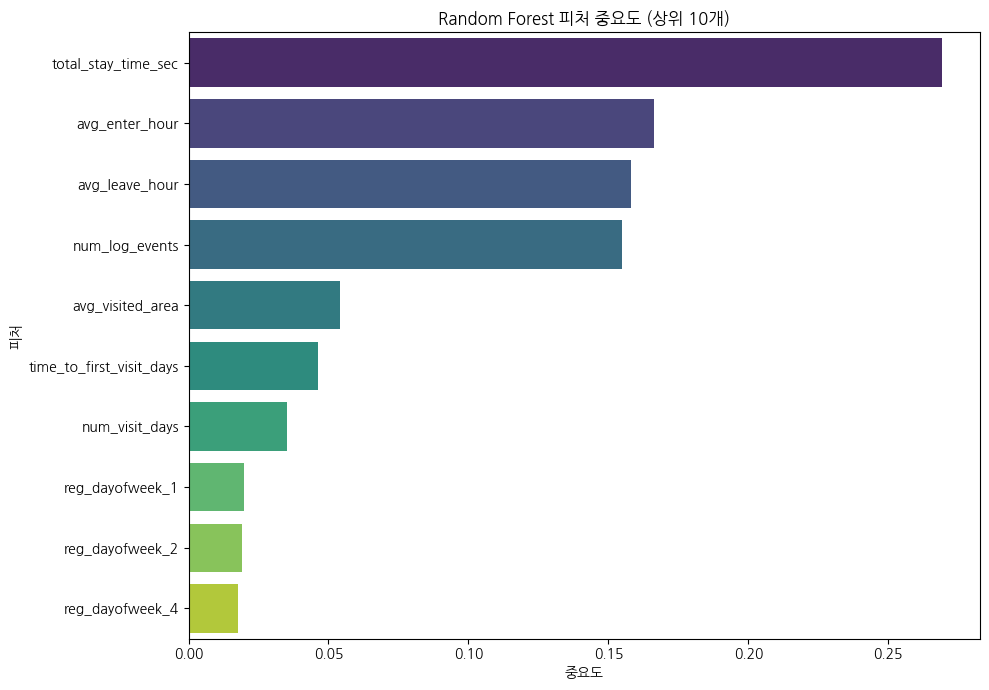

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("피처 중요도 (상위 10개):")
print(feature_importances_sorted.head(10))

# 피처 중요도 시각화
plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importances_sorted.head(10).values, y=feature_importances_sorted.head(10).index, palette='viridis')
plt.title('Random Forest 피처 중요도 (상위 10개)')
plt.xlabel('중요도')
plt.ylabel('피처')
plt.tight_layout()
plt.show()

#### 하이퍼파라미터 튜닝 - GridSearch

In [ ]:
scoring = 'f1'

In [ ]:
# 그리드 서치: 각 파라미터별 후보 값 리스트
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring=scoring, cv=5, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=73),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [ ]:
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 교차 검증 점수 ({scoring}): {grid_search.best_score_:.4f}")

최적 하이퍼파라미터: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
최적 교차 검증 점수 (f1): 0.5186


In [ ]:
best_params = grid_search.best_params_

In [ ]:
final_model = RandomForestClassifier(**best_params, random_state=73, class_weight='balanced')
final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=200, random_state=73)

In [ ]:
y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]

In [ ]:
print(f"Accuracy (정확도): {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision (정밀도): {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall (재현율): {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score (F1 점수): {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_final):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

Accuracy (정확도): 0.6596
Precision (정밀도): 0.5632
Recall (재현율): 0.5526
F1-Score (F1 점수): 0.5579
ROC-AUC Score: 0.6890

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       837
           1       0.56      0.55      0.56       532

    accuracy                           0.66      1369
   macro avg       0.64      0.64      0.64      1369
weighted avg       0.66      0.66      0.66      1369



<Figure size 800x600 with 0 Axes>

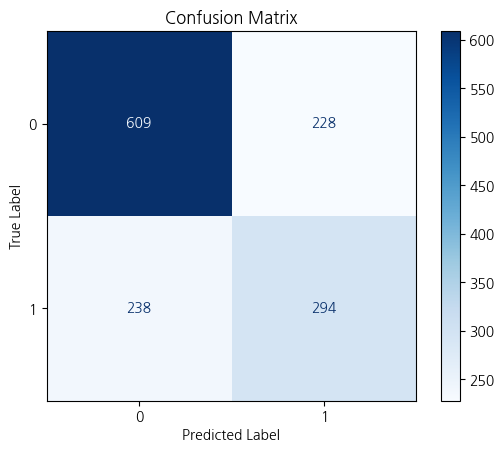

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_final)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, display_labels=[0, 1], cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### LightGBM

#### 베이스 모델

In [ ]:
import lightgbm as lgb

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73, stratify=y)

In [ ]:
lgbm_model = lgb.LGBMClassifier(objective='binary',
                                metric='auc',
                                n_estimators=100,
                                learning_rate=0.1,
                                num_leaves=31,
                                random_state=73,
                                class_weight='balanced',
                                n_jobs=-1)

In [ ]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2129, number of negative: 3344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 5473, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', metric='auc', n_jobs=-1,
               objective='binary', random_state=73)

In [ ]:
y_pred_lgbm = lgbm_model.predict(X_test)

In [ ]:
# 결제(클래스 1)일 확률
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

In [ ]:
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

In [ ]:
print(f"Accuracy (정확도): {accuracy_lgbm:.4f}")
print(f"Precision (정밀도): {precision_lgbm:.4f}")
print(f"Recall (재현율): {recall_lgbm:.4f}")
print(f"F1-Score (F1 점수): {f1_lgbm:.4f}")
print(f"ROC-AUC Score: {roc_auc_lgbm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

Accuracy (정확도): 0.6377
Precision (정밀도): 0.5321
Recall (재현율): 0.5602
F1-Score (F1 점수): 0.5458
ROC-AUC Score: 0.6646

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       837
           1       0.53      0.56      0.55       532

    accuracy                           0.64      1369
   macro avg       0.62      0.62      0.62      1369
weighted avg       0.64      0.64      0.64      1369



#### 하이퍼파라미터 튜닝 - RandomizedSearch

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
lgbm = lgb.LGBMClassifier(objective='binary',
                          random_state=73,
                          class_weight='balanced',
                          n_jobs=-1)

In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.15),
    'num_leaves': randint(20, 100),
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

In [ ]:
scoring_metric = 'f1'

In [ ]:
random_search = RandomizedSearchCV(estimator=lgbm,
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   scoring=scoring_metric,
                                   cv=5,
                                   random_state=73,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2129, number of negative: 3344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 5473, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                            objective='binary',
                                            random_state=73),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd4f1b2b8d0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd5084d34...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bd4f1b325d0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd4f1b2ac90>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd4f1b29ed0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd4f1b2afd0>},
                   random_state=73, scoring='f1')

In [ ]:
print(f"최적 하이퍼파라미터: {random_search.best_params_}")
print(f"최적 교차 검증 점수 ({scoring_metric}): {random_search.best_score_:.4f}")

최적 하이퍼파라미터: {'colsample_bytree': np.float64(0.8677174023877154), 'learning_rate': np.float64(0.03131555899155419), 'max_depth': 30, 'min_child_samples': 43, 'n_estimators': 101, 'num_leaves': 28, 'reg_alpha': np.float64(0.017232600774207407), 'reg_lambda': np.float64(0.21648487511072734), 'subsample': np.float64(0.6940657114098417)}
최적 교차 검증 점수 (f1): 0.5224


In [ ]:
# 최적 파라미터로 최종 LightGBM 모델 초기화
best_lgbm_params = random_search.best_params_
final_lgbm_model = lgb.LGBMClassifier(**best_lgbm_params,
                                      objective='binary',
                                      random_state=73,
                                      class_weight='balanced',
                                      n_jobs=-1)

In [ ]:
final_lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2129, number of negative: 3344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 5473, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               colsample_bytree=np.float64(0.8677174023877154),
               learning_rate=np.float64(0.03131555899155419), max_depth=30,
               min_child_samples=43, n_estimators=101, n_jobs=-1, num_leaves=28,
               objective='binary', random_state=73,
               reg_alpha=np.float64(0.017232600774207407),
               reg_lambda=np.float64(0.21648487511072734),
               subsample=np.float64(0.6940657114098417))

In [ ]:
# 테스트 데이터로 최종 모델 성능 평가
y_pred_final_lgbm = final_lgbm_model.predict(X_test)
y_pred_proba_final_lgbm = final_lgbm_model.predict_proba(X_test)[:, 1]

In [ ]:
print(f"Accuracy (정확도): {accuracy_score(y_test, y_pred_final_lgbm):.4f}")
print(f"Precision (정밀도): {precision_score(y_test, y_pred_final_lgbm):.4f}")
print(f"Recall (재현율): {recall_score(y_test, y_pred_final_lgbm):.4f}")
print(f"F1-Score (F1 점수): {f1_score(y_test, y_pred_final_lgbm):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_final_lgbm):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final_lgbm))

Accuracy (정확도): 0.6275
Precision (정밀도): 0.5194
Recall (재현율): 0.5545
F1-Score (F1 점수): 0.5364
ROC-AUC Score: 0.6687

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       837
           1       0.52      0.55      0.54       532

    accuracy                           0.63      1369
   macro avg       0.61      0.61      0.61      1369
weighted avg       0.63      0.63      0.63      1369



<Figure size 800x600 with 0 Axes>

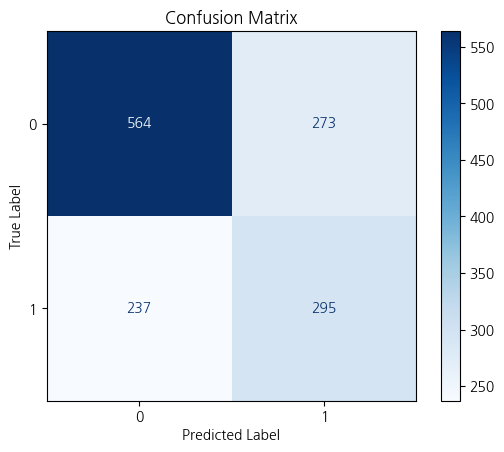

In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_final_lgbm)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final_lgbm, display_labels=[0, 1], cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 최종 모델 선정

- 모델 평가 지표: F1-Score
    - RandomForest + GridSearch
        - F1-Score는 0.56으로, 베이스라인 모델(0.47) 대비 19.7% 향상
        - 결제 예측에 있어 의미 있는 수준의 성능 개선을 달성
    - LightGBM + RandomizedSearch
        - F1-Score: 0.53



## RandomForest + GridSearch

```
[RandomForest + GridSearch]
Accuracy (정확도): 0.6596
Precision (정밀도): 0.5632
Recall (재현율): 0.5526
F1-Score (F1 점수): 0.5579
ROC-AUC Score: 0.6890

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       837
           1       0.56      0.55      0.56       532

    accuracy                           0.66      1369
   macro avg       0.64      0.64      0.64      1369
weighted avg       0.66      0.66      0.66      1369
```

### Random Forest 모델 선정 이유
- 앙상블 학습 기법(배깅) 기반
    - Random Forest는 여러 개의 독립적인 결정 트리(Dicision Tree)를 학습시킨 후 그 결과를 종합해 최종 예측을 수행하는 앙상블 기법 중 배깅(Bagging) 방식을 사용
    - 이는 단일 결정 트리가 가질 수 있는 과적합(Overfitting) 문제를 효과적으로 줄여주며, 모델의 예측 성능과 안정성을 높여줌
- 비선형 관계 학습 능력
    - 사용자의 3일 체험 행동 패턴(방문 시간, 체류 시간, 방문 순서 등)은 결제 여부와 복잡하고 비선형적인 관계
    - Random Forest는 트리 기반 모델로서 이러한 비선형적인 패턴과 피처 간의 상호작용을 잘 학습하는 능력이 뛰어남
- 다양한 데이터 타입 처리 용이
    - 수치형 피처와 범주형 피처를 모두 자연스럽게 처리할 수 있음
- 이상치 및 노이즈에 대한 강건성
    - 앙상블 모델의 특성상 데이터에 일부 이상치나 노이즈가 포함되어 있더라도 단일 모델에 비해 예측 결과가 크게 흔들리지 않음

### F1-Score 선정 이유
- 정밀도와 재현율의 평균
    - F1-Score는 재현율과 정밀도, 두 지표의 균형을 중요하게 평가
    - F1-Score를 개선한다는 것은 정밀도와 재현율 모두를 합리적인 수준으로 높인다는 의미
    - 모델이 ‘긍정’을 예측하는 정확도와 실제 ‘긍정’을 찾아내는 능력을 동시에 향상시키는 것
- 클래스 불균형 데이터에서의 유용성
    - 정확도는 클래스 불균형이 심한 데이터에서 다수 클래스를 잘 맞추는 것만으로도 높게 나올 수 있어 모델 성능을 정확히 판단하기 어려움
    - F1-Score는 소수 클래스에 대한 정밀도와 재현율을 기반으로 계산되므로, 소수 클래스 예측 성능이 우수함
    - 결제 예측 클래스의 불균형 비율이 1.63으로 비결제자가 결제자보다 많은 데이터에서 F1-Score를 개선하는 것은 모델이 실제 결제 사용자를 얼마나 효과적으로 식별하는지를 나타내는 중요한 지표!
- 단일 지표로 성능 비교 용이
    - 정밀도와 재현율 두 지표를 동시에 고려해야 할 때, F1-Score는 이 둘을 종합한 단일 지표로서 모델 간 성능을 비교하거나 하이퍼파라미터 튜닝 시 최적화 목표로 설정하기 편리
- 비즈니스 목표와의 연관성
    - 많은 실제 문제에서 정밀도와 재현율 모두 중요
    - 결제 예측의 경우
        - 높은 정밀도: ‘결제할 것이다’라고 예측된 사용자에게 마케팅 비용이나 리소스를 투입했을 때, 실제로 결제로 이어질 확률이 높다는 의미 (비용 효율성)
        - 높은 재현율: 실제 결제할 가능성이 있는 사용자를 최대한 많이 찾아내어 놓치지 않는다는 의미 (잠재 고객 확보)
    - F1-Score 개선은 이 두 가지 측면을 동시에 고려해 모델의 실용적인 가치를 높이는 데 기여